In [1]:
# Imports
import vaex
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.optimizers import RMSprop
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Data Preperation

In [2]:
timeB = 4
resolution = 7
hdf = vaex.open("data/trips/trips_grouped_" + str(timeB) + "h_r" + str(resolution) + ".hdf5")
df = hdf.to_pandas_df()

In [3]:
df.columns

Index(['start_day', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'ts_start_4_hour', 'start_4_hour',
       'start_4_hour_sin', 'start_4_hour_cos', 'pickup_hex_7', 'demand',
       'Trip Seconds', 'Trip Miles', 'Fare', 'Tips', 'Tolls', 'Extras',
       'Trip Total', 'Company_encoded', 'Taxi ID_encoded',
       'Payment Type_Dispute', 'Payment Type_Unknown', 'Payment Type_Prcard',
       'Payment Type_Cash', 'Payment Type_Credit Card', 'Payment Type_Pcard',
       'Payment Type_No Charge'],
      dtype='object')

In [4]:
# Independent variables columns
iVars = ["start_month", "start_weekday", "start_4_hour", "pickup_hex_7"]

# All interesting columns
iColumns = ["demand"] + iVars

# Select interesting columns
sdf = df[iColumns]

In [5]:
# Removing Rides without a Hexagon/ Start-Location
sdf = sdf[(sdf["pickup_hex_7"].notna()) & (sdf["pickup_hex_7"] != "None")]

In [6]:
sdf 

,demand,start_month,start_weekday,start_4_hour,pickup_hex_7
0,1604,6,6,8,872c21191ffffff
1,40,4,1,4,872c21014ffffff
2,5774,4,4,8,872c2119cffffff
3,10268,4,4,20,872c2119cffffff
4,766,4,5,16,872c21016ffffff
...,...,...,...,...,...
54085,2,4,2,20,872c21cdeffffff
54086,3,3,5,0,872c21ccbffffff
54087,1,2,5,0,872c21cd2ffffff
54088,4,4,3,12,872c21ccaffffff


In [7]:
# Devide into X andf y
data = sdf
X = data[iVars]
y = data["demand"]

# Convert Hexagon into Dummies
X = pd.get_dummies(X, columns = ["pickup_hex_7"])

# Convert into float for Keras
X = X.astype("float32")
y = y.astype("float")

In [8]:
# Print shape to know, that it fits for model
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (49710, 33)
y shape: (49710,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle= True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle = True)

In [10]:
print("X_train: "+ str(len(X_train)))
print("X_test: "+ str(len(X_test)))
print("X_val: "+ str(len(X_val)))
print("y_train: "+ str(len(y_train)))
print("y_test: "+ str(len(y_test)))
print("y_val: "+ str(len(y_val)))

X_train: 31814
X_test: 9942
X_val: 7954
y_train: 31814
y_test: 9942
y_val: 7954


In [11]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

## Jetzt wirklich NN

In [12]:
def plot_true_vs_prediction(y_pred,y_test):
    
    y_pred = y_pred.flatten()
    # create sorted series for true and predicted values
    y_pred_series = pd.Series(np.array(y_pred) ,index = y_test.index) 
    y_pred_series_sorted = y_pred_series.sort_index()
    y_test_sorted = y_test.sort_index()

    # plot true vs predicted values
    fig,ax = plt.subplots(figsize = (20, 10), dpi = 80) 
    ax.plot(y_test_sorted, label = "true", linewidth = 2, color = "tab:gray")
    ax.plot(y_pred_series_sorted, label = "prediction", linewidth = 1, alpha = 0.6, color = "tab:blue")
    ax.set_ylabel('Total System-Level Demand')
    ax.set_xlabel('Date')
    ax.legend()
    plt.show()
    
    # evaluation metrics
    print("Mean Squared Error:",mean_squared_error(y_test,y_pred))
    print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))

In [13]:
def plot_history(history):

    train_loss = history.history['loss']
    train_mae = history.history['mae']
    train_r2 = history.history['r_squared']
    val_loss = history.history['val_loss']
    val_mae = history.history['val_mae']
    val_r2 = history.history['val_r_squared']
    
    # Create an array of epochs
    #epochs = range(1, len(train_loss) + 1)
    epochs = np.arange(0, len(train_loss))

    # Plot training loss vs. validation loss
    plt.figure(figsize=(7, 3))
    #plt.plot(epochs-1, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
    # Plot log10 of training loss vs. validation loss
    #plt.figure(figsize=(10, 5))
    #plt.plot(epochs, np.log10(train_loss), 'b-', label='Training Loss')
    #plt.plot(epochs, np.log10(val_loss), 'r-', label='Validation Loss')
    #plt.title('Training and Validation Loss')
    #plt.xlabel('Epochs')
    #plt.ylabel('Log10 Loss')
    #plt.legend()
    #plt.show()
    
    # Plot training mean squared error vs. validation mae
    plt.figure(figsize=(7, 3))
    #plt.plot(epochs-1, train_mae, 'b-', label='Training MAE')
    plt.plot(epochs, train_mae, 'b-', label='Training MAE')
    plt.plot(epochs, val_mae, 'r-', label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

    # Plot log training mean squared error vs. log validation mae
    #plt.figure(figsize=(10, 5))
    #plt.plot(epochs, np.log10(train_mae), 'b-', label='Log10 Training MAE')
    #plt.plot(epochs, np.log10(val_mae), 'r-', label='Log10 Validation MAE')
    #plt.title('Training and Validation MAE')
    #plt.xlabel('Epochs')
    #plt.ylabel('MAE')
    #plt.legend()
    #plt.show()

    # Plot training r squared  vs. validation r squared
    plt.figure(figsize=(7, 3))
    #plt.plot(epochs-1, train_r2, 'b-', label='Training R^2')
    plt.plot(epochs, train_r2, 'b-', label='Training R^2')
    plt.plot(epochs, val_r2, 'r-', label='Validation R^2')
    plt.title('Training and Validation R^2')
    plt.xlabel('Epochs')
    plt.ylabel('R^2')
    plt.legend()
    plt.show()

In [14]:
def r_squared(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = 1.0 - (residual / total)
    return r2


In [15]:
# Determine the number of input layers based on X_encoded shape
num_input_layers = X.shape[1]
num_input_layers

33

In [16]:
# Define the neural network architecture
model = Sequential()
model.add(Dense(num_input_layers, activation='relu', input_shape=(num_input_layers,)))
model.add(Dense(num_input_layers, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
#model.compile(loss='mean_squared_error', optimizer='adam')
opt = RMSprop(learning_rate=0.001)
#model.compile(optimizer=opt, loss='mse', metrics=['mae'])
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])

In [17]:
# Train the model
#history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)
#model.fit(X_train, y_train, epochs=30, batch_size=32)
#history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64)
history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=50, batch_size=64)

Epoch 1/50
498/498 [==============================] - 3s 2ms/step - loss: 1088662.0000 - mae: 446.6406 - r_squared: 0.4862 - val_loss: 636863.5000 - val_mae: 312.8906 - val_r_squared: 0.7219
Epoch 2/50
498/498 [==============================] - 1s 2ms/step - loss: 556079.6250 - mae: 288.4551 - r_squared: 0.7154 - val_loss: 528597.9375 - val_mae: 275.9796 - val_r_squared: 0.7614
Epoch 3/50
498/498 [==============================] - 1s 2ms/step - loss: 465978.4688 - mae: 261.6244 - r_squared: 0.7698 - val_loss: 445588.3438 - val_mae: 266.6169 - val_r_squared: 0.7825
Epoch 4/50
498/498 [==============================] - 1s 2ms/step - loss: 419661.9375 - mae: 245.7018 - r_squared: 0.7898 - val_loss: 392178.0000 - val_mae: 244.8895 - val_r_squared: 0.8116
Epoch 5/50
498/498 [==============================] - 1s 2ms/step - loss: 381203.9375 - mae: 232.0981 - r_squared: 0.8124 - val_loss: 355572.0625 - val_mae: 228.7944 - val_r_squared: 0.8404
Epoch 6/50
498/498 [=============================

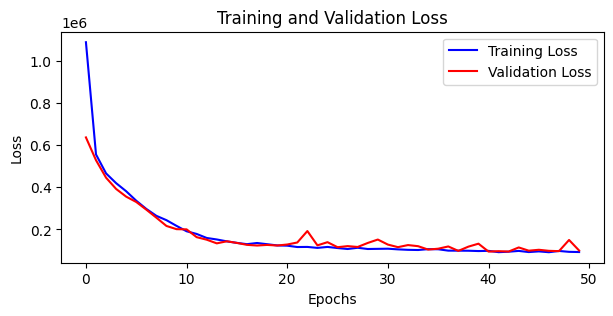

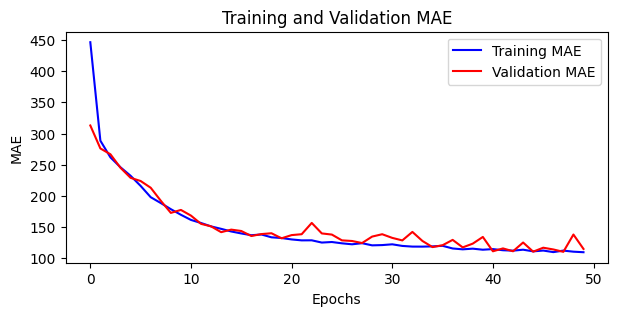

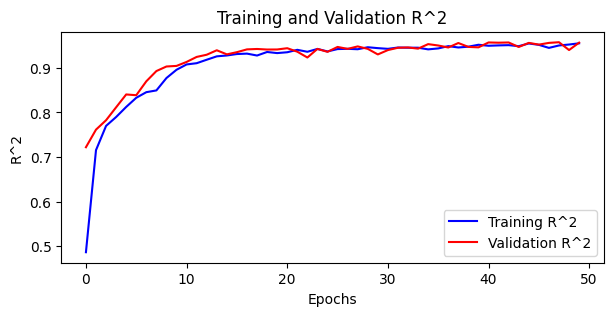

In [18]:
plot_history(history)

In [19]:
# Step 6: Evaluate the model on the test set
test_loss, test_mae, test_r2 = model.evaluate(X_test_scaled, y_test)
print("Test Loss:", test_loss)
print("Test Mean Absolute Error:", test_mae)
print("Test R^2:", test_r2)


311/311 [==============================] - 0s 1ms/step - loss: 101019.2734 - mae: 112.7556 - r_squared: 0.9433
Test Loss: 101019.2734375
Test Mean Absolute Error: 112.75563049316406
Test R^2: 0.94330894947052


311/311 [==============================] - 0s 868us/step


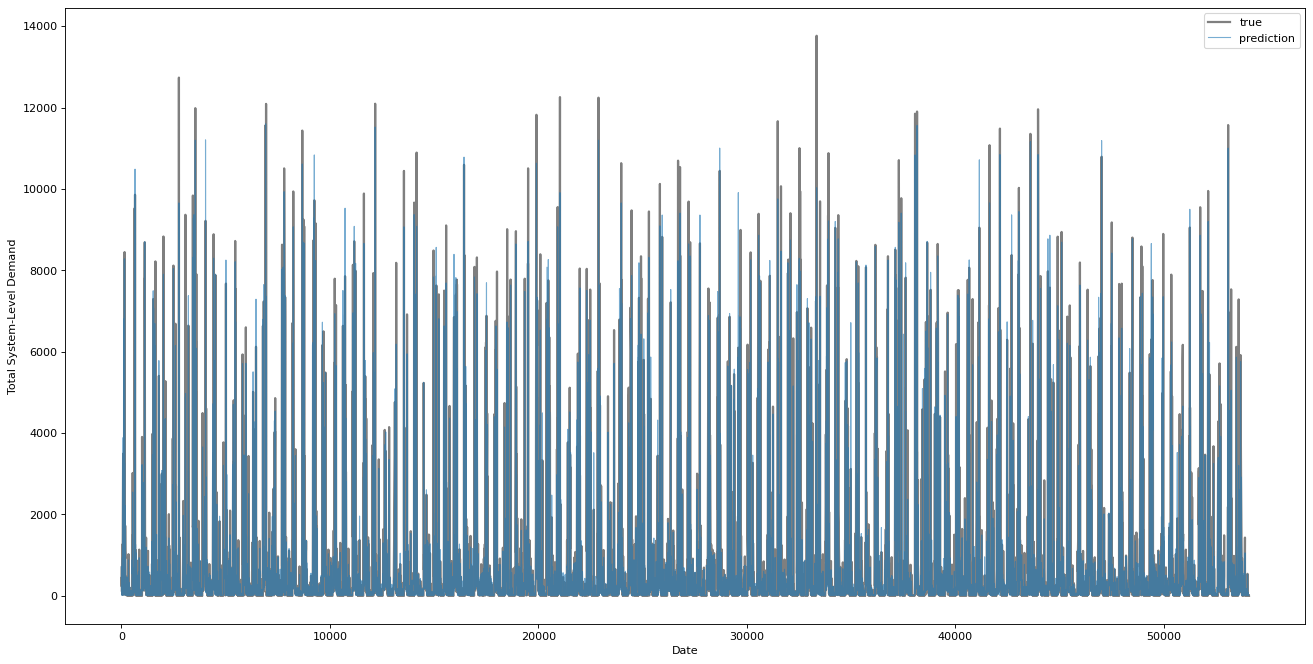

Mean Squared Error: 101019.29389149758
Mean Absolute Error: 112.75564543022473


In [20]:
plot_true_vs_prediction(model.predict(X_test_scaled),y_test)

In [21]:
example = X_test.copy()
example["demand"] = y_test

In [22]:
example["predicted_demand"] = model.predict(X_test_scaled)

311/311 [==============================] - 0s 893us/step


In [23]:
example[["start_month", "start_weekday", "start_4_hour", "demand", "predicted_demand"]]

,start_month,start_weekday,start_4_hour,demand,predicted_demand
33144,10.0,0.0,4.0,170.0,235.299896
22484,10.0,6.0,0.0,837.0,591.181824
40924,9.0,3.0,20.0,8.0,13.947689
34052,4.0,1.0,8.0,15.0,13.947689
13038,12.0,1.0,12.0,2.0,13.947689
...,...,...,...,...,...
19747,1.0,1.0,12.0,7.0,13.947689
23838,5.0,0.0,16.0,423.0,231.170319
7520,6.0,5.0,12.0,1.0,13.947689
45102,5.0,4.0,12.0,64.0,13.947689
